In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#other libraries
from tqdm import tqdm
import time
import random
import os
import sys
from pathlib import Path
import h5py

#torch specific
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor

#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from machine_learning import CalorimeterDataset
from resnet import *
from imcal import *

In [17]:
#variables controlled by the user. Change these to fit your specific needs.
VAL_PCT = 0.2 #The percentage of the data to be used as the validation set.
N_EVENTS = 1000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.

#N_LABELS = [0, 1, 2] #A list containing the classes of n number of jets we wish to train for
#LABELS = ["black_holes", "ttbar", "sphalerons"]
#FILENAMES = ["black_holes_9996_events_n.h5", "ttbar_13TeV_pTmin1000_10000_events_n.h5", "sphalerons_10000_events_n.h5"]

LABELS = ["ttbar", "directW"]
N_LABELS = [0, 1] #integer labels for the model
FILENAMES = ["ttbar_10000_events.h5", "directW_min300pTHat_10000_events.h5"]


CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
DATAPATH = Path("/disk/atlas3/data_MC/2dhistograms/") #The path to the folder containing the histogram files
RES = 100 #resolution

MODEL_NAME = f'resnet' + str(int(time.time())) #A unique name for the model
print(MODEL_NAME)

"""
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
"""
device = torch.device("cpu")

resnet1661776060


In [4]:
def load_hd5_histogram(path:Path):
    """
    Loads the data as numpy array. Opens the file and extracts the data before closing it again.
    """
    with h5py.File(path) as f:
        print (f.keys())
        data = f["images"]
        #create array
        arr = np.array(data)[0:N_EVENTS]
        print(f"Loaded data with {len(arr)} entries of shape {np.shape(arr)}")
        print(f"Check max value: {np.max(arr)}")
        #This is where normalisation happens
        arr[arr>2000] = 2000
        arr = (arr/2000)*255
        return Tensor(arr)

def label_maker(nclasses:list, nevents:int):
    #Creates labels for the classes. The first class gets value [1, 0, .., 0], the next [0, 1, ..., 0] etc
    a = torch.zeros(nevents*len(nclasses), len(nclasses), dtype=torch.int)
    for i in range(len(nclasses)):
        for j in range(nevents):
            a[nevents*i + j][i] = 1
    return a

def load_data(input_files, data_path):
    #Loads the data files
    val_size = int(N_EVENTS*VAL_PCT)
    train_size = int(N_EVENTS*(1-VAL_PCT))
    data = [load_hd5_histogram(data_path / file) for file in input_files]
    #Partitions off training data
    Cal_train = torch.cat([item[0:train_size] for item in data]).float().to(device)
    labels_train = label_maker(N_LABELS, train_size).float().to(device)
    #Testing data
    Cal_test = torch.cat([item[(train_size):(train_size+val_size)] for item in data]).float().to(device)
    labels_test = label_maker(N_LABELS, val_size).float().to(device)
    #Check everything is ok
    print(f"Data has shape {Cal_test[0].shape}. {len(labels_train)} training images and {len(labels_test)} testing images")
    
    transforms = torchv.transforms.Compose([
        torchv.transforms.RandomHorizontalFlip(),
        torchv.transforms.RandomVerticalFlip()
        #Add random scrolling
        ])

    train_dataset = CalorimeterDataset(Cal_train, labels_train, transform=transforms)
    test_dataset = CalorimeterDataset(Cal_test, labels_test)
    
    return train_dataset, test_dataset

In [18]:
#load data
traindata, testdata = load_data(FILENAMES, DATAPATH)

<KeysViewHDF5 ['Events', 'Filters', 'Input', 'Resolution', 'images']>
Loaded data with 1000 entries of shape (1000, 100, 100, 3)
Check max value: 17177.828125
<KeysViewHDF5 ['Events', 'Filters', 'Input', 'Resolution', 'images']>
Loaded data with 1000 entries of shape (1000, 100, 100, 3)
Check max value: 8157.48193359375
Data has shape torch.Size([100, 100, 3]). 1600 training images and 400 testing images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0, 0, 0, 0], [1, 1, 1, 1]]
[[24, 21, 23, 94], [295, 254, 261, 259]]
Image shape:  torch.Size([100, 100, 3])


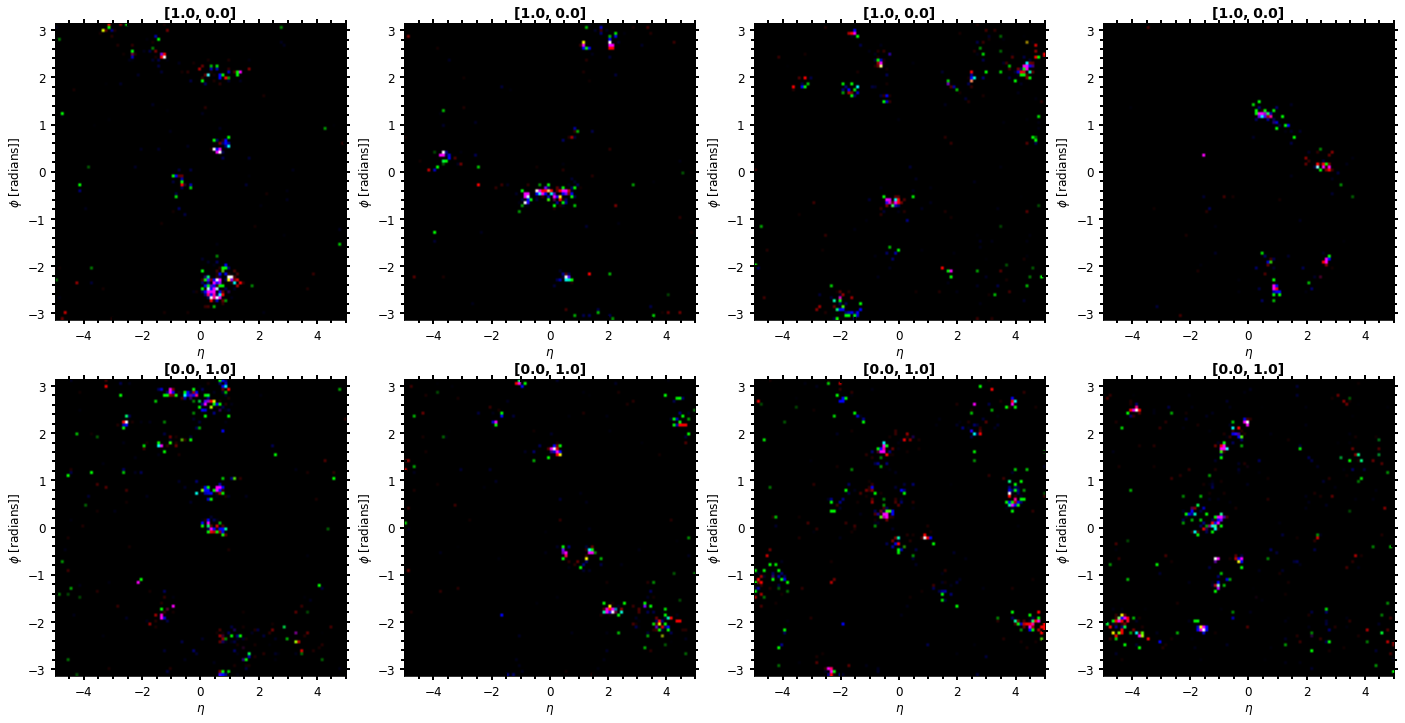

In [19]:
view_data(testdata, 4, CLASSES, N_EVENTS*(VAL_PCT))

### Create net and train

In [8]:
#create NN and test that nothing major is wrong.
from resnet import ResNet18
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(device = device)
optimizer = optim.Adam(resnet.parameters(), lr=0.0005)
testimage, testlabel = traindata.images[0], traindata.img_labels[0]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(device)))

torch.Size([1, 3, 100, 100])
tensor([[-0.4351, -0.1150]], grad_fn=<AddmmBackward0>)


In [9]:
training_results = train(resnet, traindata, testdata, 50, 1, RES, device, optimizer)


100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


0    0.00
1    0.80
2    0.82
3    0.80
Name: Validation accuracy, dtype: float64


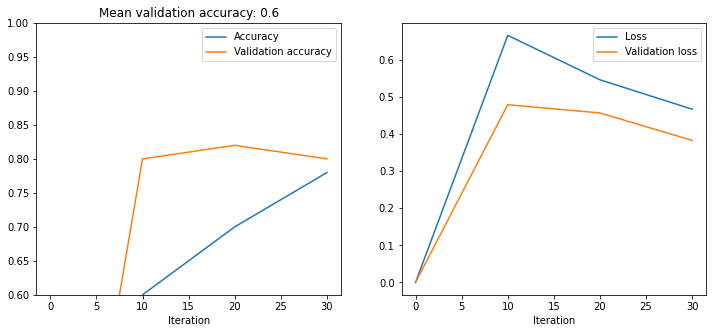

In [10]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
axs[0].set_ylim(0.6, 1)
print(training_results["Validation accuracy"])

In [11]:
from sklearn.metrics import accuracy_score
truth, preds = predict(resnet, testdata, 100, RES, device)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 4/4 [00:00<00:00,  7.42it/s]

400


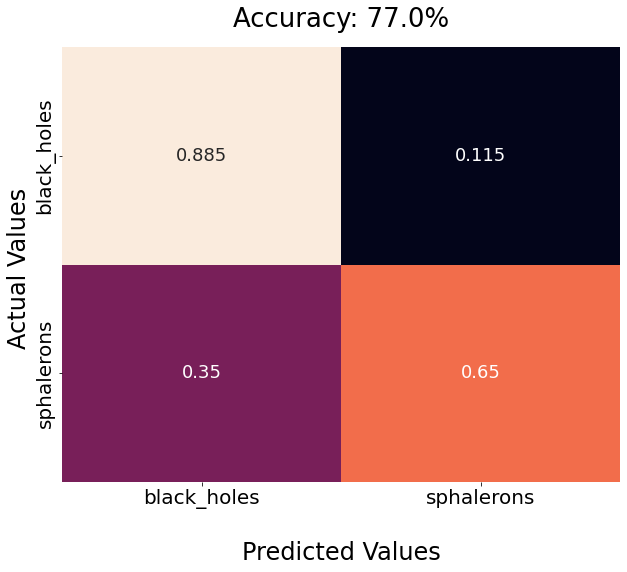

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

fig, ax = plt.subplots(figsize = (10, 8))

#Generate the confusion matrix
cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
cf_matrix = np.round(cf_matrix, 3)
ax = sn.heatmap(cf_matrix, annot=True, cbar=False, cmap='rocket', fmt='g',annot_kws={"size": 18})

#ax.set_title('Confusion matrix\n\n', size=24)
ax.set_xlabel('\nPredicted Values', size=24)
ax.set_ylabel('Actual Values ', size=24)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(LABELS, size=20)
ax.yaxis.set_ticklabels(LABELS, size=20)
ax.set_title(f"Accuracy: {round(accuracy, 2)*100}%", size=26, pad=20)

## Display the visualization of the Confusion Matrix.
plt.show()